#### CPU core residency analysis during inferring LLM cluster

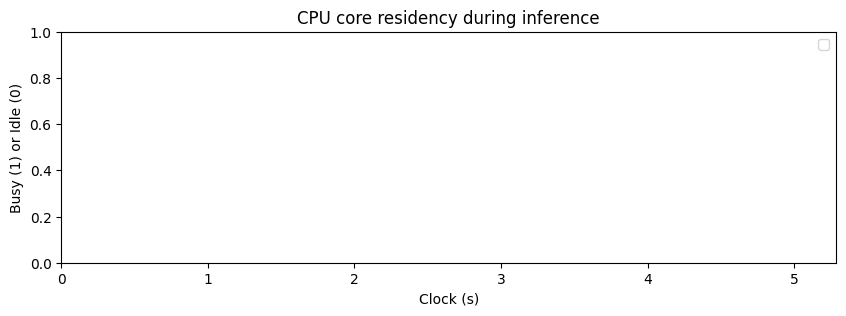

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_loc = '../results/0/splitwise_27_13/test_trace/40_0/bloom-176b/mixed_pool'

df_raw = pd.read_csv(data_loc + '/cpu_usage/cpu_usage_0.csv')
# replace all True to 1 and False to 0
df = df_raw.drop(columns=['clock'])
df = df.applymap(lambda x: True if isinstance(x, str) and x else False)
df['clock'] = df_raw['clock']

# Read the CSV file
df_sim = pd.read_csv(data_loc + '/simulator.csv')

# Filter the rows where the event is 'end'
end_event = df_sim[df_sim['event'] == 'end']

# Extract the time of the 'end' event
duration = end_event['time'].values[0]

# Create a complete range of clock values from 0 to duration
clock_range = pd.DataFrame({'clock': np.arange(0, duration, step=0.01)})

# Merge the clock range with the existing data
df = pd.merge(clock_range, df, on='clock', how='left')

# Fill missing values with 0 and forward fill the core values
df.fillna(0, inplace=True)
df.ffill(inplace=True)

plt.figure(figsize=(10, 3))

# Plot each core column as a step function
for column in df.columns:
    if column.startswith('core'):
        plt.step(df['clock'], df[column], where='post', label=f'CPU {column} residency')

plt.title('CPU core residency during inference')
plt.xlabel('Clock (s)')
plt.ylabel('Busy (1) or Idle (0)')
plt.xlim(0, duration)  # Set x-axis limits
plt.legend('')
plt.show()

In the system model, each core maps to a physical core. This is because we disable hyper-threading since public clouds do have security concerns with H/T enabled, thus turning off H/T is favourable (need a proof). Then, we can use the core power model derived to estimate the power consumption of the CPU.

In [14]:
df_server = df_raw[df_raw['id'] == 88]
print(df_server)
df_server.plot(x='clock', y='c-state', figsize=(10, 3))

     c-state     clock  id       model     power
88        C0  1.000000  88  bloom-176b  2.665096
344       C6  2.332643  88         NaN  0.100000
600       C6  3.000000  88         NaN  0.100000
856       C6  3.536055  88         NaN  0.100000
1112      C6  4.000000  88         NaN  0.100000
1368      C6  4.536055  88         NaN  0.100000


TypeError: no numeric data to plot

In [11]:
from core_power import get_c_state_from_idle_governor, get_core_power_for_model, calculate_core_power


def generate_cpu_data(df_raw=None):
    """Generate CPU data for analysis.
    Reads the raw event log of the CPU and generates a detailed event log with idle state and power consumption.
    """
    # Transform from wide to long format to have one row per core per clock
    df_long = df_raw.melt(id_vars=['clock'], var_name='core', value_name='model')
    
    # replace Nan with None
    df_long['model'] = df_long['model'].apply(lambda x: None if pd.isna(x) else x)
    
    # Extract core ID from 'core' column
    df_long['id'] = df_long['core'].str.replace('core_', '').astype(int)
    
    # drop column 'core'
    df_long = df_long.drop(columns=['core'])
    
    # Sort the DataFrame by 'ID' and 'clock' to prepare for c-state calculation
    df_long = df_long.sort_values(by=['id', 'clock']).reset_index(drop=True)
    
    # Initialize 'c-state' and 'power' columns
    df_long['c-state'] = None
    df_long['power'] = None
    
    # Group the DataFrame by 'ID' (core ID)
    grouped = df_long.groupby('id')
    
    # Apply 'calculate_c_state' and 'calculate_power' functions
    for core_id, group in grouped:
        # Sort the group by 'clock' to ensure proper time sequence
        group = group.sort_values(by='clock')
        
        # Iterate over each row in the group
        for index, row in group.iterrows():
            # Get past records up to the current time
            past_records = group.iloc[:index+1]
            
            def get_idle_durations(past_records):
                # Ensure DataFrame is sorted by 'clock' for chronological order
                past_records = past_records.sort_values(by="clock")
            
                idle_durations = []
                idle_start = 0.0
                
                for _, row in past_records.iterrows():
                    if pd.isna(row['model']):  # Core is idle
                        if idle_start is None:  # Start of idle period
                            idle_start = row['clock']
                    else:  # Core is busy
                        if idle_start is not None:  # End of idle period
                            idle_durations.append(row['clock'] - idle_start)
                            idle_start = None  # Reset idle start
            
                return idle_durations
            
            idle_durations = get_idle_durations(past_records=past_records)
            
            # Calculate c-state for the current row
            c_state = get_c_state_from_idle_governor(last_8_idle_durations_s=idle_durations[:max(8, len(idle_durations))])
            df_long.loc[row.name, 'c-state'] = c_state['state']
            
            # Calculate power for the current row
            power = calculate_core_power(c_state=c_state, model=row['model'])
            df_long.loc[row.name, 'power'] = power
    
    df_long.sort_values(by=['clock'], inplace=True)
    
    return df_long

example = generate_cpu_data(df_raw=df_raw)
example.to_csv('output/example.csv')
print(example)

ImportError: cannot import name 'calculate_core_power' from 'core_power' (/Users/tharindu/workspace/splitwise-sim/core_power.py)